# One-dimensional advection

In this notebook we tackle simulating the one-dimensional advectiobn equation,

$$ \partial_t c + \partial_x (u c) = 0 $$

where $c$ is a tracer and $u$ is the $x$-velocity, which is going to be constant in this notebook.
To start let's try simulating the evolution of $c$ with $u=1$ starting from a "top hat" initial condition

$$ c(t=0) = \left \{ \begin{matrix}
1 \qquad \text{if} \quad |x| < 1 \\
0 \qquad \text{if} \quad |x| \ge 1 \\
\end{matrix} \right . $$

up until $t=1$.
We'll use the domain $z \in [-4, 8]$ to give the tracer distribution room to move to the right.
Here's a script that does it:

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (246.375 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (312.417 μs).
[ Info: Simulation is stopping after running for 1.951 ms.
[ Info: Model iteration 10 equals or exceeds stop iteration 10.


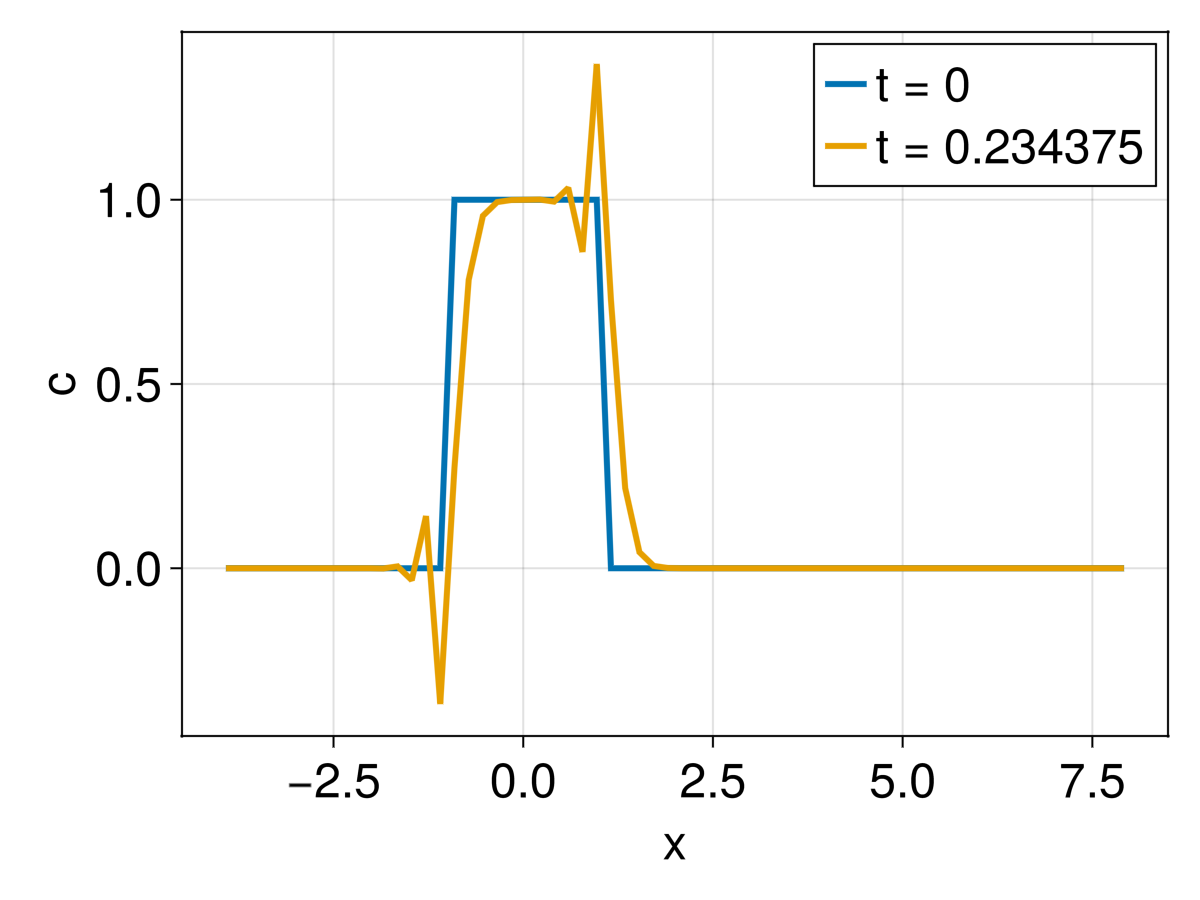

In [45]:
using Oceananigans
using GLMakie
set_theme!(Theme(fontsize=24, linewidth=3))

# Make a grid
grid = RectilinearGrid(size=64, x=(-4, 8), topology=(Periodic, Flat, Flat))

# Build a model with one tracer and a constant, Laplacian (scalar) diffusivity
u = XFaceField(grid)
set!(u, 1)
tracer_advection = CenteredSecondOrder()
velocities = PrescribedVelocityFields(u=u)
model = HydrostaticFreeSurfaceModel(; grid, tracer_advection, velocities, buoyancy=nothing, tracers=:c)

# Set the initial condition
set!(model, c= x -> abs(x) > 1 ? 0 : 1)

# Make a plot of the initial condition
c = interior(model.tracers.c, :, 1, 1)
x = xnodes(model.tracers.c)
lines(x, c, label="t = 0", axis=(xlabel="x", ylabel="c"))

# Build and run a simulation
Δt = 0.1 * 15/grid.Nx 
simulation = Simulation(model; Δt, stop_iteration=10)
run!(simulation)

# Plot the final state
lines!(x, c, label=string("t = ", time(simulation)))
axislegend()
current_figure()

Interesting.
After 10 iteration, the tracer distribution did move to the right a bit, but it's also exhibiting weird oscillations, especially around the "corners" of the top hat.
The reason this happens is specifically because of the advection scheme,

In [46]:
model.advection.c

Centered reconstruction order 2 
 Boundary scheme: 
    └── Nothing
 Directions:
    ├── X regular 
    ├── Y regular 
    └── Z regular

a "centered second-order" advection scheme.
This scheme is "dispersive", which means that, at leading order, it's errors are wave-like and exhibit oscillations.
What's more, the solution displays "false extrema" --- that is, during the simulation $c$ acquires values that are greater than or less than the values contained in the initial condition.
For a tracer that isn't forced, that should be impossible.

To fix the problem we need to use an advection scheme that's better suited for this problem, which has no explicit dissipation or diffusion of $c$.
One such scheme is the "Weighted Essentially Non-Oscillatory" scheme, which is an adaptive scheme that provides high-order accuracy when the solution is smooth, but lower order accuracy when the solution varies sharply.
We'll start with a 5th order scheme (Oceananigans supports up to order 11):

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (281.958 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (327.208 μs).
[ Info: Simulation is stopping after running for 2.091 ms.
[ Info: Model iteration 10 equals or exceeds stop iteration 10.


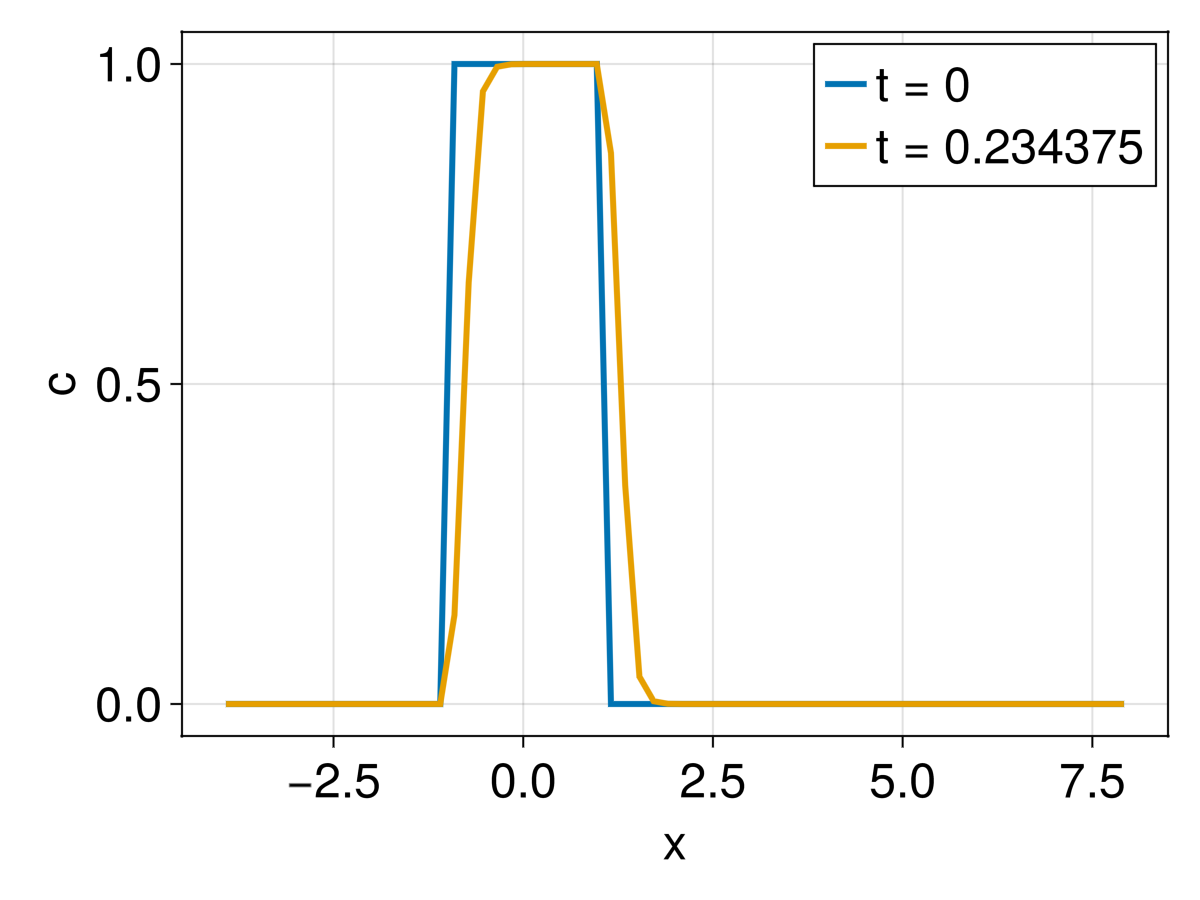

In [47]:
tracer_advection = WENO(order=5)
model = HydrostaticFreeSurfaceModel(; grid, tracer_advection, velocities, buoyancy=nothing, tracers=:c)

# Set the initial condition
set!(model, c= x -> abs(x) > 1 ? 0 : 1)

# Make a plot of the initial condition
c = interior(model.tracers.c, :, 1, 1)
x = xnodes(model.tracers.c)
lines(x, c, label="t = 0", axis=(xlabel="x", ylabel="c"))

# Build and run a simulation
Δt = 0.1 * 15/grid.Nx 
simulation = Simulation(model; Δt, stop_iteration=10)
run!(simulation)

# Plot the final state
lines!(x, c, label=string("t = ", time(simulation)))
axislegend()
current_figure()

Let's run it for a little longer to see how things develop.

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (1.446 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (969.375 μs).
[ Info: Simulation is stopping after running for 28.146 ms.
[ Info: Model iteration 210 equals or exceeds stop iteration 210.


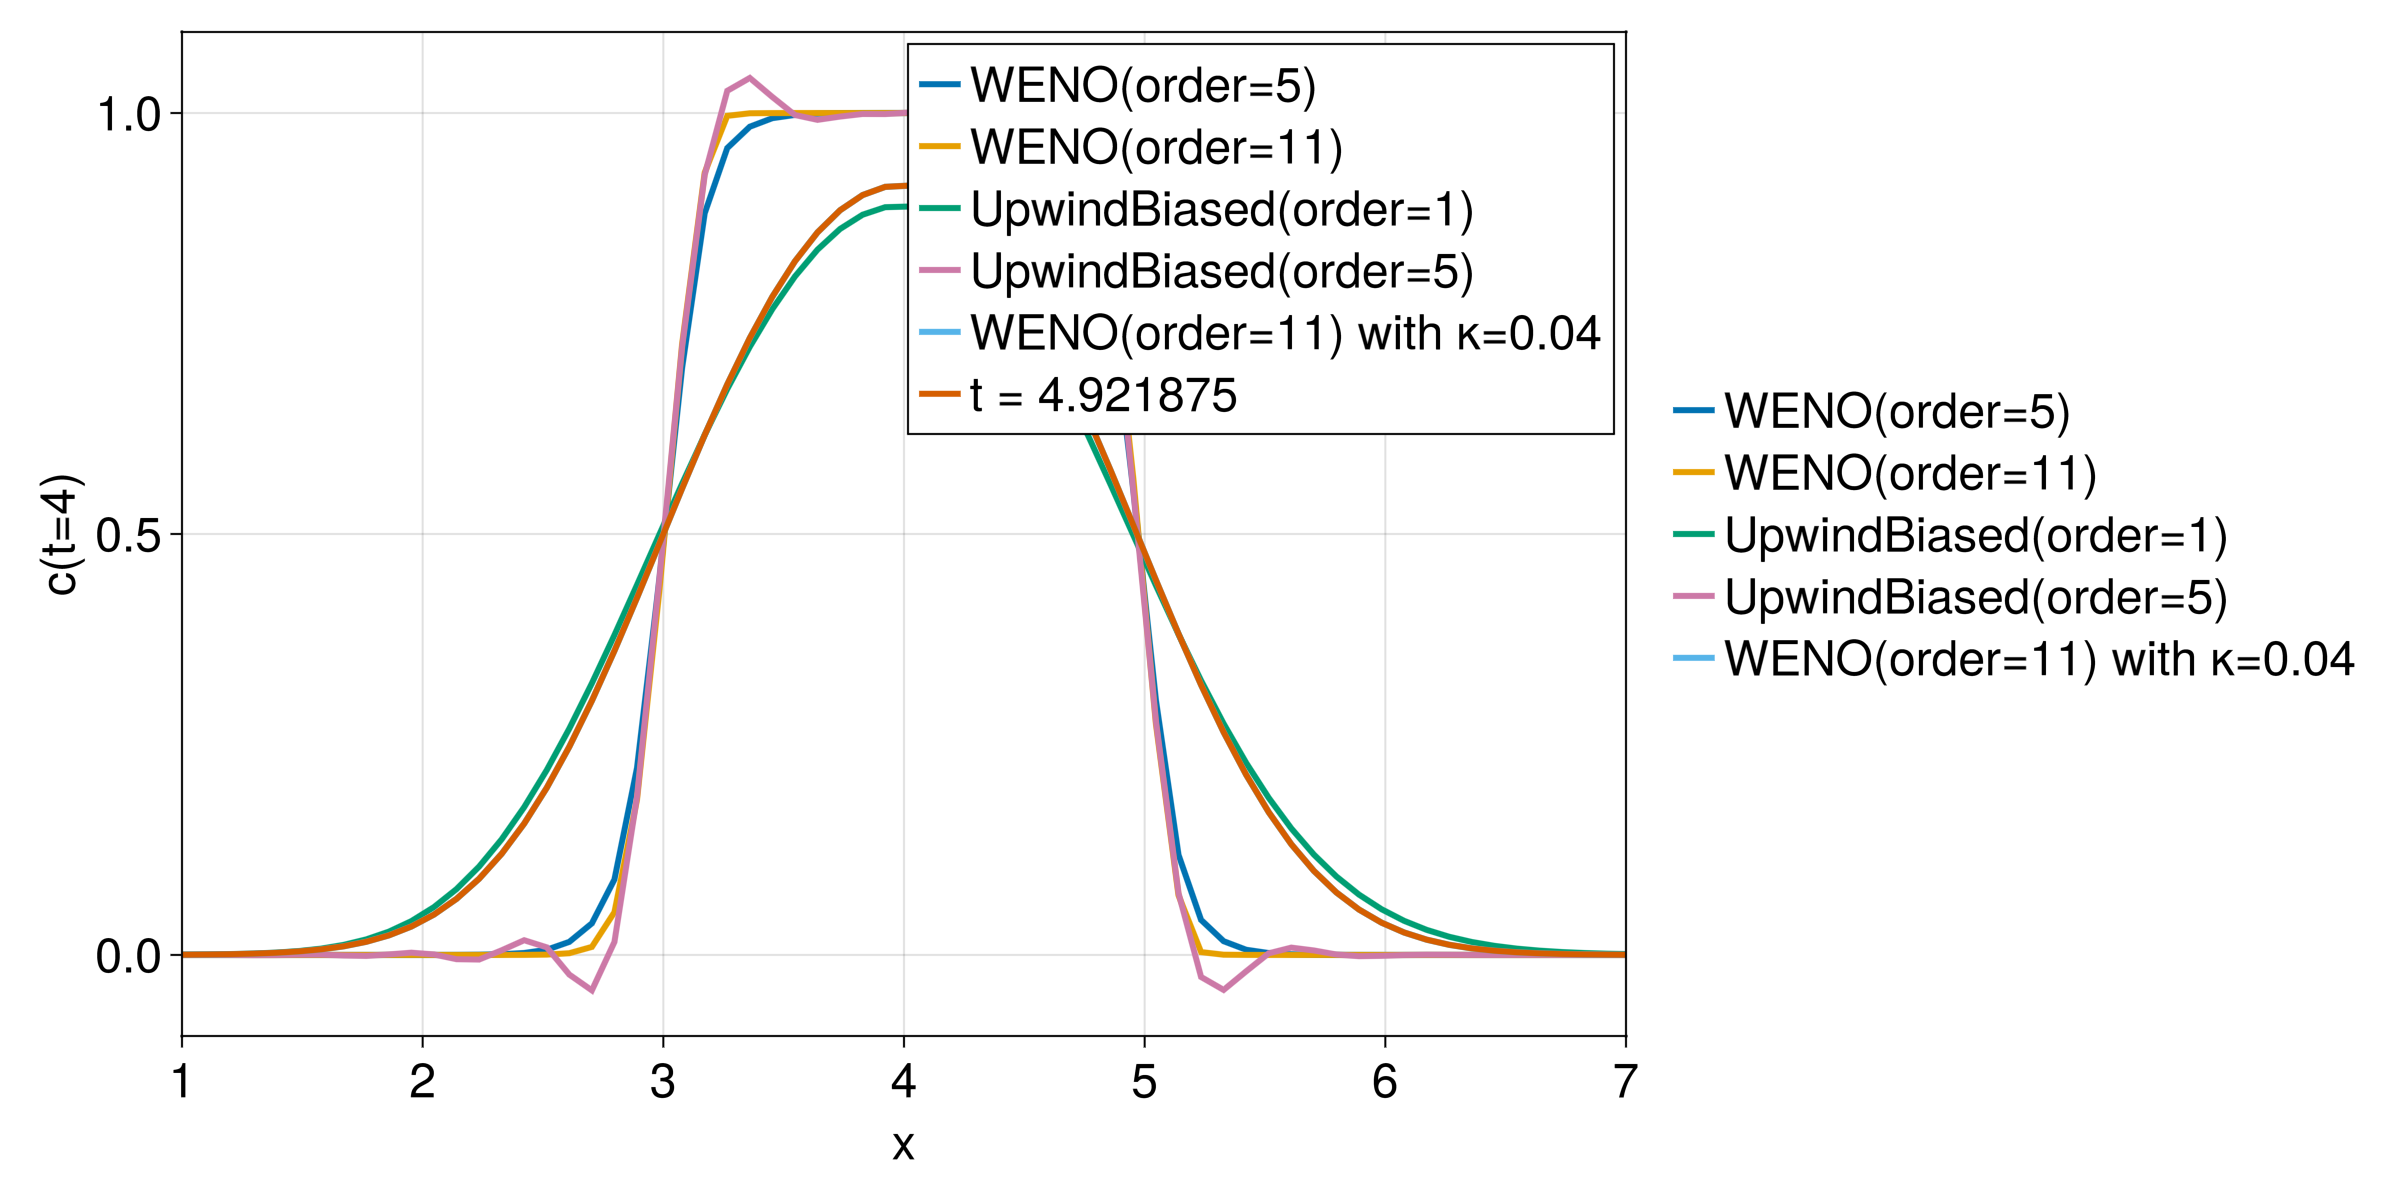

In [50]:
simulation.stop_iteration += 100
run!(simulation)
lines!(x, c, label=string("t = ", time(simulation)))
axislegend()
current_figure()

Next lets investigate a bunch of different schemes.
This also illustrates Oceananigans flexibility.
We don't have to go outside of julia to run many simulations and illustrate something.
We can simply write a function that performs an Oceananigans simulation.

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (180.250 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (362.167 μs).
[ Info: Simulation is stopping after running for 57.557 ms.
[ Info: Simulation time 4 seconds equals or exceeds stop time 4 seconds.
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (239.834 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (456.333 μs).
[ Info: Simulation is stopping after running for 88.600 ms.
[ Info: Simulation time 4 seconds equals or exceeds stop time 4 seconds.
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (164.375 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (353.875 μs).
[ Info: Simulation is stopping after running for 55.583 ms.
[ Info: Simulation time 4 seconds equals or exceeds stop time 4 seconds.
[ Info: Initiali

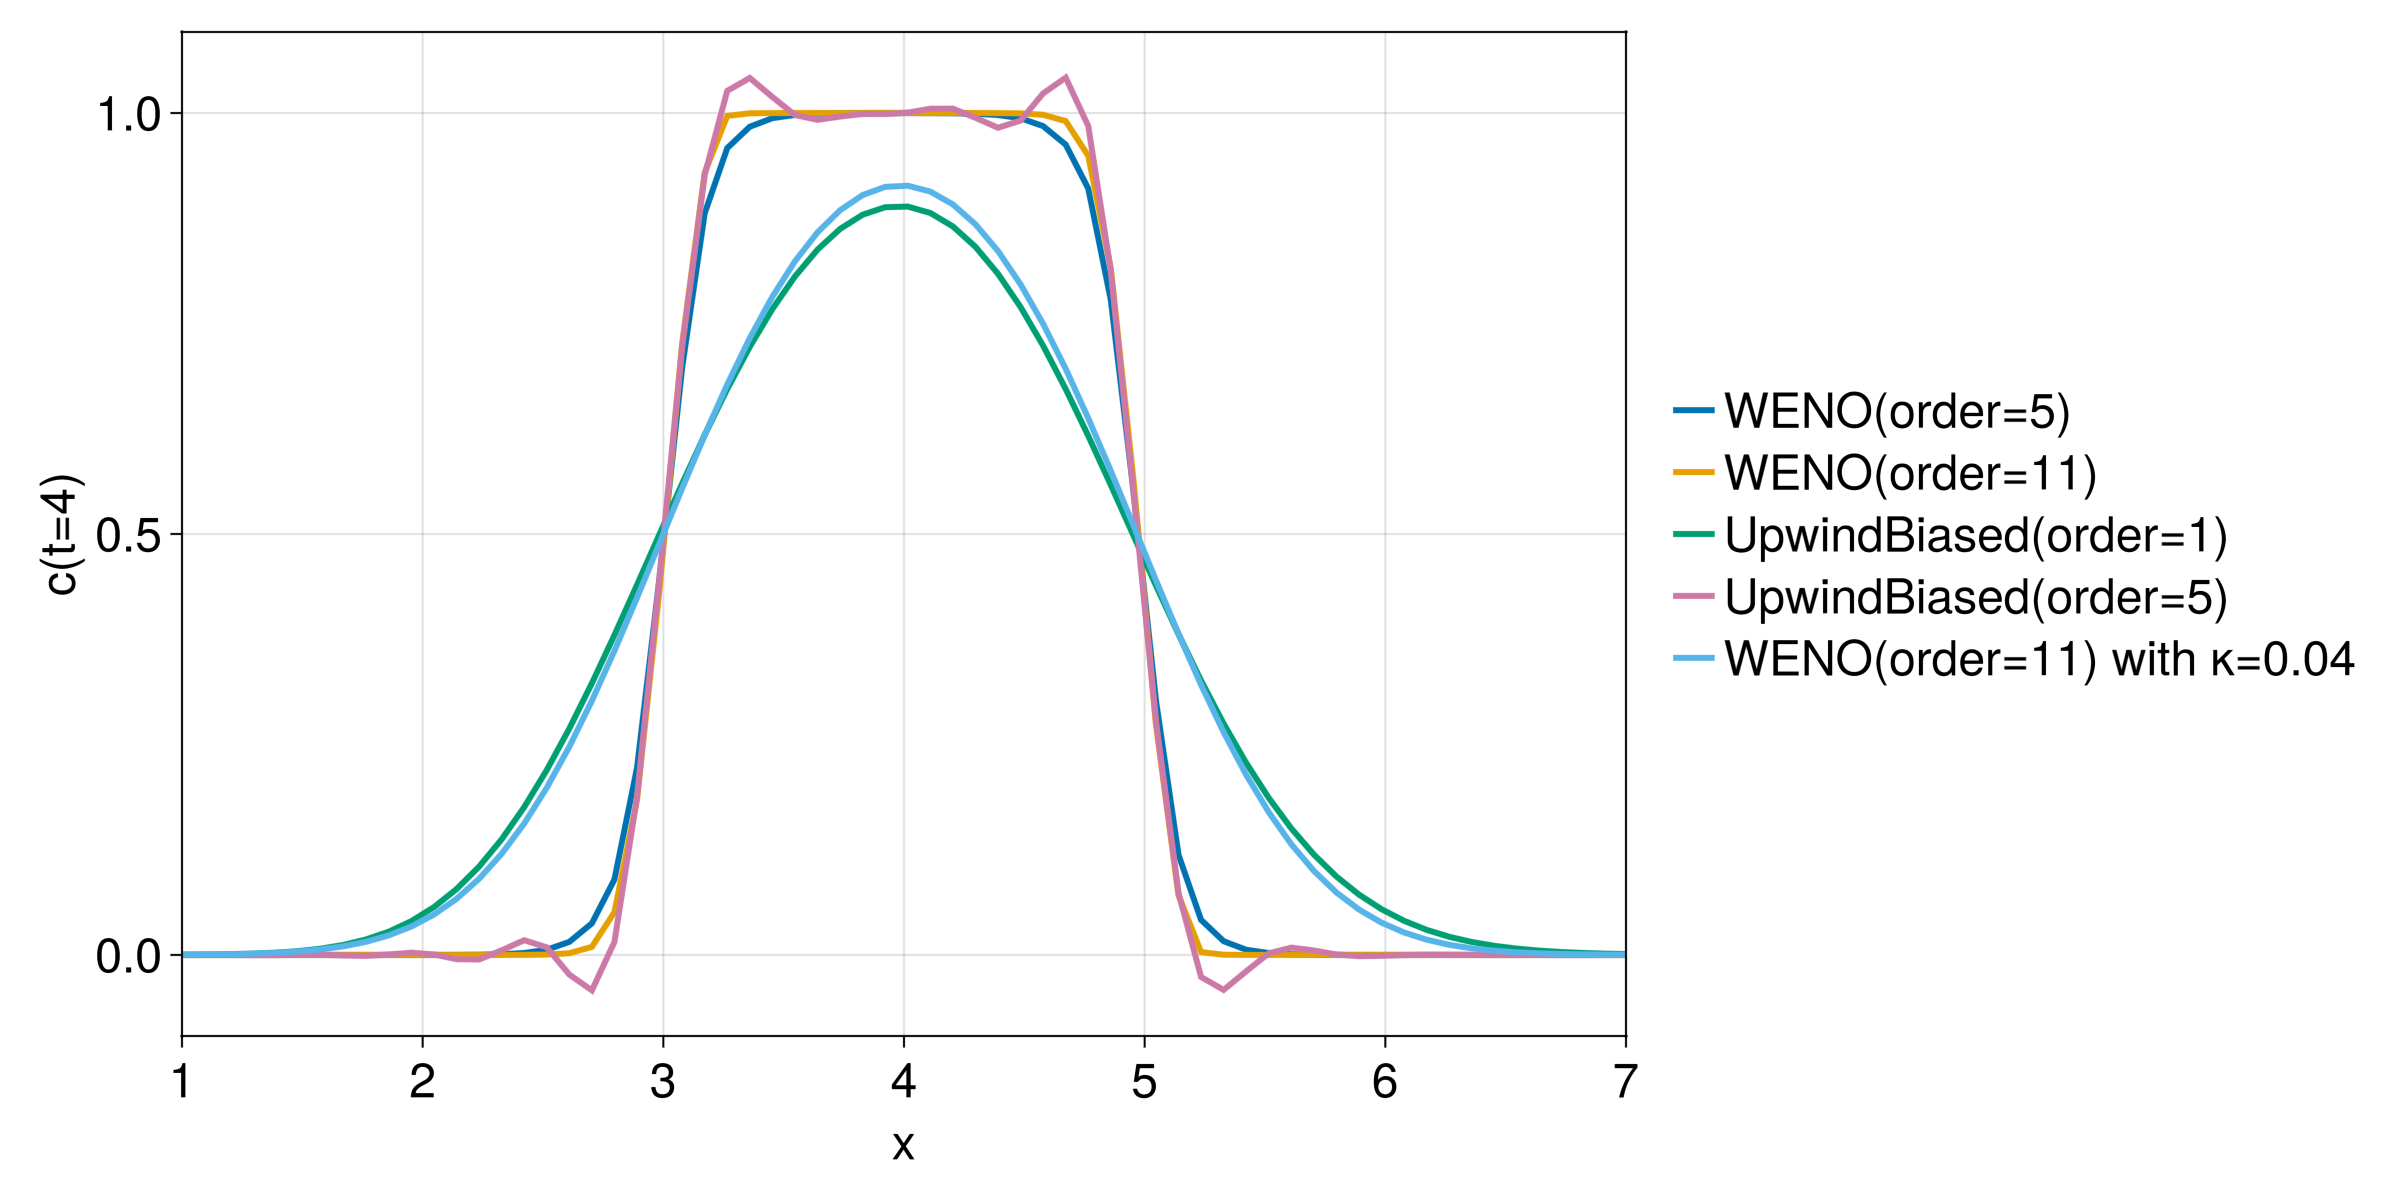

In [52]:
"""
    advect_tracer(advection_scheme, Nx=128, stop_time=4)

Advect a tracer with a top-hat profile until `stop_time` using `Nx` grid points.
Returns `x, c`.
"""
function advect_tracer(advection_scheme; closure=nothing, Nx=128, stop_time=4)
    # Make a grid
    grid = RectilinearGrid(size=Nx, x=(-4, 8), halo=7, topology=(Periodic, Flat, Flat))

    # Build a model with one tracer and a constant, Laplacian (scalar) diffusivity
    u = XFaceField(grid)
    set!(u, 1)
    velocities = PrescribedVelocityFields(u=u)
    model = HydrostaticFreeSurfaceModel(; grid, closure, velocities,
                                        tracer_advection = advection_scheme,
                                        buoyancy = nothing,
                                        tracers = :c)

    # Set the initial condition
    set!(model, c= x -> abs(x) > 1 ? 0 : 1)
    
    # Build and run a simulation
    Δt = 0.1 * 12/Nx 
    simulation = Simulation(model; Δt, stop_time)
    run!(simulation)
    
    c = interior(model.tracers.c, :, 1, 1)
    x = xnodes(model.tracers.c)
    
    return x, c
end

fig = Figure(size=(1200, 600))
ax = Axis(fig[1, 1], xlabel="x", ylabel="c(t=4)")

for N = (5, 11)
    scheme = WENO(order=N)
    x, c = advect_tracer(scheme)
    lines!(ax, x, c, label="WENO(order=$N)")
end

for N = (1, 5)
    x, c = advect_tracer(UpwindBiased(order=N))
    lines!(ax, x, c, label="UpwindBiased(order=$N)")
end

x, c = advect_tracer(WENO(order=11), closure=ScalarDiffusivity(κ=0.04))
lines!(ax, x, c, label="WENO(order=11) with κ=0.04")

Legend(fig[1, 2], ax, framevisible=false)
xlims!(ax, 1, 7)
fig

Unpack this:

* `WENO(order=11)` is the least diffusive of all
* `UpwindBiased(order=5)` is not too diffusive, but also has dispersive errors!
* `UpwindBiased(order=1)` is very diffusive. So diffusive in fact, its the same as imposing a Laplacian diffusivity with κ=0.04. It'd be cool if you can derive this coefficient!